In [64]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, product
from scipy.special import softmax
import torch.nn 

# General settings

In [65]:
NUMBER_OF_LANDMARKS = 3
N_STEPS = 100_000
DELTA = 1
EGREEDY = 0.0

# Only cooperative goals

In [66]:
scores = np.eye(NUMBER_OF_LANDMARKS)
P_DIFFERENT_GOALS = 0.3

for i in range(scores.shape[0]):
    for j in range(scores.shape[1]):
        if i !=j:
            scores[i,j] = P_DIFFERENT_GOALS
n_goals = scores.shape[0]

scores0 = scores1 = scores


scores1 = np.array([
    [0.8, 0, 0.1],
    [0, 1, 0.2],
    [0.7, 0.8, 0.9]
])

scores0 = np.array([
    [0.8, 0, 0.1],
    [0.1, 1, 0],
    [0.2, 0, 0.9]
])

## One matrix per agent

In [67]:
# Alignment for all seeds
a0 = []
a1 = []

for s in range(10):
    np.random.seed(s)
    agent_0 = np.zeros_like(scores)
    agent_1 = np.zeros_like(scores)
    for i in range(N_STEPS):
        leader_goal_index = np.random.randint(0, n_goals)
        if np.random.random() < 0.5:
            # Agent 0 leader
            if np.random.random() < EGREEDY:
                leader_msg_index = np.random.choice(range(scores.shape[0]))
            else:
                leader_msg_index = np.argmax(agent_0[leader_goal_index])
            if np.random.random() < EGREEDY:
                follower_goal_index = np.random.choice(range(scores.shape[0]))
            else:
                follower_goal_index = np.argmax(agent_1[:, leader_msg_index])
            leader_reward = np.random.random() < scores0[leader_goal_index, follower_goal_index]
            follower_reward = np.random.random() < scores1[follower_goal_index, leader_goal_index]
            if leader_reward:
                agent_0[leader_goal_index, :] -= DELTA
                agent_0[leader_goal_index, leader_msg_index] += (leader_reward + 1) * DELTA
            else:
                agent_0[leader_goal_index, leader_msg_index] -= DELTA
            if follower_reward:
                agent_1[:, leader_msg_index] -= DELTA
                agent_1[follower_goal_index, leader_msg_index] += (follower_reward + 1) * DELTA
            else:
                agent_1[follower_goal_index, leader_msg_index] -= DELTA

        else:
            # Agent 1 leader
            if np.random.random() < EGREEDY:
                leader_msg_index = np.random.choice(range(scores.shape[0]))
            else:
                leader_msg_index = np.argmax(agent_1[leader_goal_index])
            if np.random.random() < EGREEDY:
                follower_goal_index = np.random.choice(range(scores.shape[0]))
            else:
                follower_goal_index = np.argmax(agent_0[:, leader_msg_index])
            leader_reward = np.random.random() < scores1[leader_goal_index, follower_goal_index]
            follower_reward = np.random.random() < scores0[follower_goal_index, leader_goal_index]
            if leader_reward:
                agent_1[leader_goal_index, :] -= DELTA
                agent_1[leader_goal_index, leader_msg_index] += (leader_reward + 1) * DELTA
            else:
                agent_1[leader_goal_index, leader_msg_index] -= DELTA
            if follower_reward:
                agent_0[:, leader_msg_index] -= DELTA
                agent_0[follower_goal_index, leader_msg_index] += (follower_reward + 1) * DELTA
            else:
                agent_0[follower_goal_index, leader_msg_index] -= DELTA

    alignment_0_leader = []
    for i in range(0, n_goals):
        msg = np.argmax(agent_0[i])
        j = np.argmax(agent_1[:, msg])
        alignment_0_leader.append(i==j)

    alignment_1_leader = []
    for i in range(0, n_goals):
        msg = np.argmax(agent_1[i])
        j = np.argmax(agent_0[:, msg])
        alignment_1_leader.append(i==j)
        
    a0.append(sum(alignment_0_leader)/len(alignment_0_leader))
    a1.append(sum(alignment_1_leader)/len(alignment_1_leader))

In [68]:
print(f"Alignment for agent 0: {np.mean(a0)}")
print(f"Alignment for agent 1: {np.mean(a1)}")

Alignment for agent 0: 1.0
Alignment for agent 1: 1.0


## Two matrices per agent

In [69]:
# Alignment for all seeds
a0 = []
a1 = []

for s in range(10):
    np.random.seed(s)
    agent_0 = np.zeros_like(scores)
    agent_1 = np.zeros_like(scores)
    agent_0f = np.zeros_like(scores)
    agent_1f = np.zeros_like(scores)

    for i in range(N_STEPS):
        leader_goal_index = np.random.randint(0, n_goals)
        if np.random.random() < 0.5:
            # Agent 0 leader
            if np.random.random() < EGREEDY:
                leader_msg_index = np.random.choice(range(scores.shape[0]))
            else:
                leader_msg_index = np.argmax(agent_0[leader_goal_index])
            if np.random.random() < EGREEDY:
                follower_goal_index = np.random.choice(range(scores.shape[0]))
            else:
                follower_goal_index = np.argmax(agent_1f[leader_msg_index])
            leader_reward = np.random.random() < scores0[leader_goal_index, follower_goal_index]
            follower_reward = np.random.random() < scores1[follower_goal_index, leader_goal_index]
            if leader_reward:
                agent_0[leader_goal_index, :] -= DELTA
                agent_0[leader_goal_index, leader_msg_index] += (leader_reward + 1) * DELTA
            else:
                agent_0[leader_goal_index, leader_msg_index] -= DELTA
            if follower_reward:
                agent_1f[leader_msg_index] -= DELTA
                agent_1f[leader_msg_index, follower_goal_index] += (follower_reward + 1) * DELTA
            else:
                agent_1f[leader_msg_index, follower_goal_index] -= DELTA

        else:
            # Agent 1 leader
            if np.random.random() < EGREEDY:
                leader_msg_index = np.random.choice(range(scores.shape[0]))
            else:
                leader_msg_index = np.argmax(agent_1[leader_goal_index])
            if np.random.random() < EGREEDY:
                follower_goal_index = np.random.choice(range(scores.shape[0]))
            else:
                follower_goal_index = np.argmax(agent_0f[leader_msg_index])
            leader_reward = np.random.random() < scores1[leader_goal_index, follower_goal_index]
            follower_reward = np.random.random() < scores0[follower_goal_index, leader_goal_index]
            if leader_reward:
                agent_1[leader_goal_index, :] -= DELTA
                agent_1[leader_goal_index, leader_msg_index] += (leader_reward + 1) * DELTA
            else:
                agent_1[leader_goal_index, leader_msg_index] -= DELTA
            if follower_reward:
                agent_0f[leader_msg_index] -= DELTA
                agent_0f[leader_msg_index, follower_goal_index] += (follower_reward + 1) * DELTA
            else:
                agent_0f[leader_msg_index, follower_goal_index] -= DELTA

    alignment_0_leader = []
    for i in range(0, n_goals):
        msg = np.argmax(agent_0[i])
        j = np.argmax(agent_1f[msg])
        alignment_0_leader.append(i==j)

    alignment_1_leader = []
    for i in range(0, n_goals):
        msg = np.argmax(agent_1[i])
        j = np.argmax(agent_0f[msg])
        alignment_1_leader.append(i==j)
        
    a0.append(sum(alignment_0_leader)/len(alignment_0_leader))
    a1.append(sum(alignment_1_leader)/len(alignment_1_leader))

In [70]:
print(f"Alignment for agent 0: {np.mean(a0)}")
print(f"Alignment for agent 1: {np.mean(a1)}")

Alignment for agent 0: 0.8
Alignment for agent 1: 0.8666666666666668


# All goals

In [71]:
# Probability of success when solving an individual goal
P_INDIVIDUAL = 1.0
# Probability of success when solving a collective goal, and the other agent is following the same goal
P_COLLECTIVE_SAME = 1.0
# Probability of success when solving a collective goal, and the other agent is solving an individual but compatible goal (e.g 101 and 001)
P_COLLECTIVE_INDIVIDUAL_COMPAT = 0.0
# Probability of success when solving a collective goal, and the other agent is solving another "compatible" collective goal (e.g 101 and 011)
P_COLLECTIVE_COLLECTIVE_COMPAT = 0.0

In [72]:
individual_goals = np.eye(NUMBER_OF_LANDMARKS, dtype=np.uint8).tolist()
collective_goals = np.array(list(combinations(individual_goals, 2))).sum(1).tolist()
goal_space = individual_goals + collective_goals
n_goals = len(goal_space)
n_individual = len(individual_goals)

In [73]:
n_goals**2

36

In [74]:
# scores(own_goal, other_goal) = probability of reward for that agent
scores = np.zeros((n_goals, n_goals))
# setting individual goals scores
scores[:n_individual, :] = P_INDIVIDUAL
# setting for collective goals
for n in range(n_individual, n_goals):
    # compatible collective goals
    for i in range(n_individual, n_goals):
        if np.bitwise_or.reduce([goal_space[n], goal_space[i]]).sum() == 3:
            scores[n, i] = P_COLLECTIVE_COLLECTIVE_COMPAT
    # compatible collective + individual goals
    for i in range(n_individual):
        if np.bitwise_or.reduce([goal_space[n], goal_space[i]]).sum() == 2:
            scores[n, i] = P_COLLECTIVE_INDIVIDUAL_COMPAT    
    # same collective goals
    scores[n, n] = P_COLLECTIVE_SAME

In [75]:
scores

array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [76]:
a0_all = []
a1_all = []
cooperative_factors = range(1, 100, 10)
for b in cooperative_factors:
    # # Double matrix full communication naming game double matrices
    a0 = []
    a1 = []
    for s in range(5):
        np.random.seed(s)
        agent_0 = np.zeros_like(scores)
        agent_1 = np.zeros_like(scores)

        agent_0f = np.zeros_like(scores)
        agent_1f = np.zeros_like(scores)


        rewards_0 = []
        rewards_1 = []
        alignment = []

        EGREEDY = 0.15
        EGREEDY = 0.05

        for i in range(N_STEPS):
            leader_goal_index = np.random.randint(0, n_goals)
            if np.random.random() < 0.5:
                # Agent 0 leader
                # egreedy
                if EGREEDY:
                    if np.random.random() < EGREEDY:
                        leader_msg_index = np.random.choice(range(scores.shape[0]))
                    else:
                        leader_msg_index = np.argmax(agent_0[leader_goal_index])
                    if np.random.random() < EGREEDY:
                        follower_goal_index = np.random.choice(range(scores.shape[0]))
                    else:
                        follower_goal_index = np.argmax(agent_1f[leader_msg_index])
                else:
                    leader_scores = torch.nn.functional.softmax(torch.Tensor(agent_0[leader_goal_index])).numpy()
                    leader_scores /= sum(leader_scores)
                    leader_msg_index = np.random.choice(range(scores.shape[0]), p=leader_scores)
                    follower_scores = torch.nn.functional.softmax(torch.Tensor(agent_1f[leader_msg_index])).numpy()
                    follower_scores /= sum(follower_scores)
                    follower_goal_index = np.random.choice(range(scores.shape[0]), p=follower_scores)
                leader_reward = np.random.random() < scores[leader_goal_index, follower_goal_index]
                follower_reward = np.random.random() < scores[follower_goal_index, leader_goal_index]
                # Collective reward adjustment
                if leader_goal_index > n_individual -1:
                    leader_reward *= b
                if follower_goal_index > n_individual -1:
                    follower_reward *= b
                rewards_0.append(leader_reward)
                rewards_1.append(follower_reward)
                if leader_reward:
                    agent_0[leader_goal_index, :] -= DELTA
                    agent_0[leader_goal_index, leader_msg_index] += (leader_reward + 1) * DELTA
                else:
                    agent_0[leader_goal_index, leader_msg_index] -= DELTA
                if follower_reward:
                    agent_1f[leader_msg_index, :] -= DELTA
                    agent_1f[leader_msg_index, follower_goal_index] += (follower_reward + 1) * DELTA
                else:
                    agent_1f[leader_msg_index, follower_goal_index] -= DELTA

            else:
                # Agent 1 leader
                if EGREEDY:
                    if np.random.random() < EGREEDY:
                        leader_msg_index = np.random.choice(range(scores.shape[0]))
                    else:
                        leader_msg_index = np.argmax(agent_1[leader_goal_index])
                    if np.random.random() < EGREEDY:
                        follower_goal_index = np.random.choice(range(scores.shape[0]))
                    else:
                        follower_goal_index = np.argmax(agent_0f[leader_msg_index])
                else:
                    leader_scores = torch.nn.functional.softmax(torch.Tensor(agent_1[leader_goal_index])).numpy()
                    leader_scores /= sum(leader_scores)
                    leader_msg_index = np.random.choice(range(scores.shape[0]), p=leader_scores)
                    follower_scores = torch.nn.functional.softmax(torch.Tensor(agent_0f[leader_msg_index])).numpy()
                    follower_scores /= sum(follower_scores)
                    follower_goal_index = np.random.choice(range(scores.shape[0]), p=follower_scores)
                leader_reward = np.random.random() < scores[leader_goal_index, follower_goal_index]
                follower_reward = np.random.random() < scores[follower_goal_index, leader_goal_index]
                # Collective reward adjustment
                if leader_goal_index > n_individual -1:
                    leader_reward *= b
                if follower_goal_index > n_individual -1:
                    follower_reward *= b
                rewards_1.append(leader_reward)
                rewards_0.append(follower_reward)
                if leader_reward:
                    agent_1[leader_goal_index, :] -= DELTA
                    agent_1[leader_goal_index, leader_msg_index] += (leader_reward + 1) * DELTA
                else:
                    agent_1[leader_goal_index, leader_msg_index] -= DELTA
                if follower_reward:
                    agent_0f[leader_msg_index, :] -= DELTA
                    agent_0f[leader_msg_index, follower_goal_index] += (follower_reward + 1) * DELTA
                else:
                    agent_0f[leader_msg_index, follower_goal_index] -= DELTA

            if leader_goal_index > n_individual - 1:
                alignment.append(leader_goal_index == follower_goal_index)

        alignment_0_leader = []
        for i in range(n_individual, n_goals):
            msg = np.argmax(agent_0[i])
            j = np.argmax(agent_1f[msg])
            alignment_0_leader.append(i==j)

        alignment_1_leader = []
        for i in range(n_individual, n_goals):
            msg = np.argmax(agent_1[i])
            j = np.argmax(agent_0f[msg])
            alignment_1_leader.append(i==j)
            
        a0.append(sum(alignment_0_leader)/len(alignment_0_leader))
        a1.append(sum(alignment_1_leader)/len(alignment_1_leader))
    a0_all.append(a0)
    a1_all.append(a1)


Text(0, 0.5, "Alignment for leader's cooperative goal")

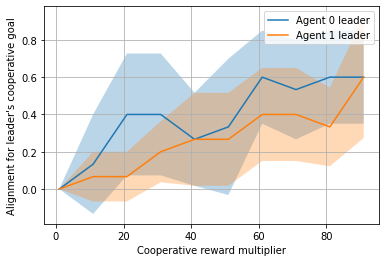

In [77]:
plt.plot(cooperative_factors, np.mean(a0_all, axis=1), label="Agent 0 leader")
plt.fill_between(cooperative_factors, np.mean(a0_all, axis=1) - np.std(a0_all, axis=1), np.mean(a0_all, axis=1)+ np.std(a0_all, axis=1), alpha=0.3)
plt.legend()
plt.plot(cooperative_factors, np.mean(a1_all, axis=1), label="Agent 1 leader")
plt.fill_between(cooperative_factors, np.mean(a1_all, axis=1) - np.std(a1_all, axis=1), np.mean(a1_all, axis=1)+ np.std(a1_all, axis=1), alpha=0.3)
plt.legend()
plt.grid()
plt.xlabel("Cooperative reward multiplier")
plt.ylabel("Alignment for leader's cooperative goal")
